<a href="https://colab.research.google.com/github/elvispletsch/-Avaliacao-de-Propostas-de-Fornecedores/blob/main/Projeto_de_Webscrapping_Elvis_Alan_Pletsch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Modelo 'pt_core_news_lg' não encontrado. Instalando...
Total de notícias coletadas: 150
Total de textos processados: 150
Exemplo de matriz Bag of Words:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


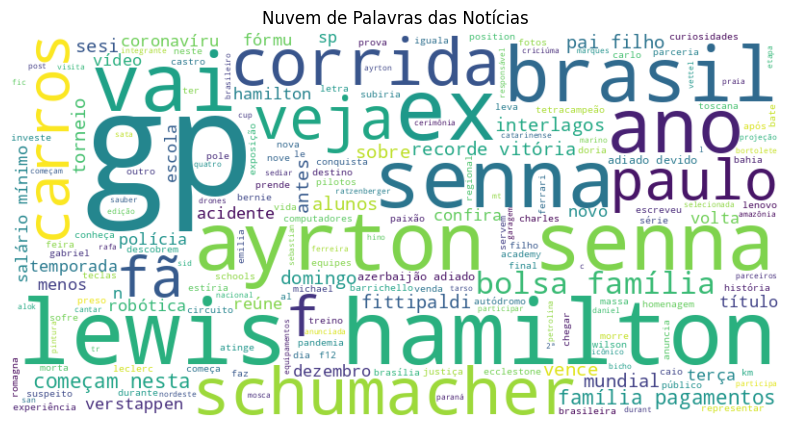

Tópico 1: ['gp', 'senna', 'adiado', 'azerbaijão', 'devido']
Tópico 2: ['senna', 'família', 'gp', 'bolsa', 'pagamentos']
Tópico 3: ['maringaense', 'próximo', 'horários', 'gp', 'estíria']
Tópico 4: ['ex', 'gp', 'academy', 'verstappen', 'vence']
Tópico 5: ['hamilton', 'lewis', 'vitórias', 'recorde', 'gp']
Texto 1 pertence ao Tópico 5
Texto 2 pertence ao Tópico 1
Texto 3 pertence ao Tópico 2
Texto 4 pertence ao Tópico 1
Texto 5 pertence ao Tópico 3
Texto 6 pertence ao Tópico 5
Texto 7 pertence ao Tópico 4
Texto 8 pertence ao Tópico 4
Texto 9 pertence ao Tópico 2
Texto 10 pertence ao Tópico 4
Texto 11 pertence ao Tópico 4
Texto 12 pertence ao Tópico 4
Texto 13 pertence ao Tópico 5
Texto 14 pertence ao Tópico 2
Texto 15 pertence ao Tópico 5
Texto 16 pertence ao Tópico 5
Texto 17 pertence ao Tópico 1
Texto 18 pertence ao Tópico 2
Texto 19 pertence ao Tópico 5
Texto 20 pertence ao Tópico 3
Texto 21 pertence ao Tópico 5
Texto 22 pertence ao Tópico 3
Texto 23 pertence ao Tópico 5
Texto 24 perten

In [1]:
# Importação das bibliotecas necessárias
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import spacy
import networkx as nx
import csv
from itertools import combinations

# Configurações iniciais para evitar erros de pacotes
nltk.download('stopwords')

# Stopwords padrão e personalizadas (evitam ruído nos dados)
stop_words = set(stopwords.words('portuguese'))
minhas_stopwords = {"fórmula", "1", "f1", "piloto", "equipe", "um", "carro", "notícia", "notícias", "globo", "g1"}  # Palavras irrelevantes ao contexto
todas_stopwords = stop_words.union(minhas_stopwords)

# Tokenizador para capturar apenas palavras e remover pontuações
tokenizador = RegexpTokenizer(r'\w+')

# Configuração do SpaCy e instalação do modelo em português, se necessário
try:
    nlp = spacy.load("pt_core_news_lg")
except OSError:
    print("Modelo 'pt_core_news_lg' não encontrado. Instalando...")
    import os
    os.system("python -m spacy download pt_core_news_lg")
    nlp = spacy.load("pt_core_news_lg")

# Coleta de dados via web scraping
total_paginas = 10  # Número de páginas que queremos analisar
noticias_coletadas = []

for pagina in range(1, total_paginas + 1):
    pesquisa = "f1"
    url = f"https://g1.globo.com/busca/?q={pesquisa}&page={pagina}"
    resposta = requests.get(url)
    sopa = BeautifulSoup(resposta.content, 'html.parser')

    # Busca os blocos de texto das notícias na página
    blocos_noticias = sopa.find_all('div', class_='widget--info__text-container')
    for bloco in blocos_noticias:
        titulo = bloco.find('div', class_='widget--info__title')
        if titulo:
            noticias_coletadas.append(titulo.text.strip())

print(f"Total de notícias coletadas: {len(noticias_coletadas)}")

# Pré-processamento dos textos
textos_processados = []
for noticia in noticias_coletadas:
    texto_limpo = noticia.lower()  # Coloca tudo em letras minúsculas
    tokens = tokenizador.tokenize(texto_limpo)  # Tokeniza removendo pontuações
    tokens_filtrados = [palavra for palavra in tokens if palavra not in todas_stopwords]
    textos_processados.append(' '.join(tokens_filtrados))

print(f"Total de textos processados: {len(textos_processados)}")

# Representação de Bag of Words
vetorizador = CountVectorizer()
matriz_bow = vetorizador.fit_transform(textos_processados)

print("Exemplo de matriz Bag of Words:\n", matriz_bow.toarray())

# Geração de nuvem de palavras para visualização
texto_completo = ' '.join(textos_processados)
nuvem_palavras = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

plt.figure(figsize=(10, 5))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras das Notícias")
plt.show()

# Análise de Tópicos com LDA
vetorizador_tfidf = TfidfVectorizer()
matriz_tfidf = vetorizador_tfidf.fit_transform(textos_processados)

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Ajusta número de tópicos
lda.fit(matriz_tfidf)

# Mostrando os principais termos de cada tópico
nomes_features = vetorizador_tfidf.get_feature_names_out()
for i, topico in enumerate(lda.components_):
    print(f"Tópico {i + 1}: {[nomes_features[i] for i in topico.argsort()[:-6:-1]]}")

# Classificação dos textos em tópicos
classificacao_topicos = lda.transform(matriz_tfidf).argmax(axis=1)
for idx, topico in enumerate(classificacao_topicos):
    print(f"Texto {idx + 1} pertence ao Tópico {topico + 1}")

# Extração de Entidades Nomeadas
entidades_encontradas = {"Pessoas": set(), "Organizações": set()}

for texto in textos_processados:
    doc = nlp(texto)
    for entidade in doc.ents:
        if entidade.label_ == "PER":
            entidades_encontradas["Pessoas"].add(entidade.text)
        elif entidade.label_ == "ORG":
            entidades_encontradas["Organizações"].add(entidade.text)

print("Entidades extraídas:")
print("Pessoas:", entidades_encontradas["Pessoas"])
print("Organizações:", entidades_encontradas["Organizações"])

# Criação de grafo com as entidades
pares_coocorrencias = []
for texto in textos_processados:
    doc = nlp(texto)
    entidades_no_texto = set(entidade.text for entidade in doc.ents if entidade.label_ in ["PER", "ORG"])
    for par in combinations(entidades_no_texto, 2):
        pares_coocorrencias.append(par)

# Construção do grafo e da matriz de adjacência
grafo = nx.Graph()
grafo.add_edges_from(pares_coocorrencias)
matriz_adjacencia = nx.adjacency_matrix(grafo).todense()

# Salva matriz de adjacência em arquivo CSV
with open("matriz_adjacencia.csv", "w", newline="") as arquivo_csv:
    escritor = csv.writer(arquivo_csv)
    escritor.writerow(grafo.nodes)  # Cabeçalho com os nós
    escritor.writerows(matriz_adjacencia)

print("Matriz de adjacência salva como 'matriz_adjacencia.csv'.")
